In [1]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape, Dense, Embedding, LSTM,GRU, Bidirectional, TimeDistributed
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:



In [10]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


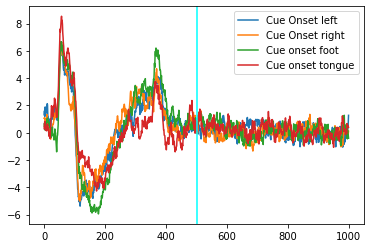

In [11]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


In [12]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [7]:
# Creating the training and validation sets

# First generating the training and validation indices using random splitting

num_samples = 237
num_samples_valid = 50

ind_valid = np.random.choice(num_samples, num_samples_valid, replace=False)
ind_train = np.array(list(set(range(num_samples)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


# # stratified split
# from sklearn.model_selection import train_test_split
# x_train, x_valid, y_train, y_valid = train_test_split(X_train_valid,y_train_valid,test_size=50/237, stratify=y_train_valid)



print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (187, 22, 1000)
Shape of validation set: (50, 22, 1000)
Shape of training labels: (187,)
Shape of validation labels: (50,)
Shape of training labels after categorical conversion: (187, 4)
Shape of validation labels after categorical conversion: (50, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (187, 22, 1000, 1)
Shape of validation set after adding width info: (50, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (187, 1000, 1, 22)
Shape of validation set after dimension reshaping: (50, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


In [13]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width i

In [17]:
gru_model = Sequential()
#1
gru_model.add(GRU(50, return_sequences=True, stateful=False,
         recurrent_dropout=0.6, dropout = 0.5, input_shape=(250,22)))

#2
gru_model.add(GRU(25, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.5))

#3
gru_model.add(GRU(25, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.5))
gru_model.add(Flatten())

#4
gru_model.add(Dense(20))
gru_model.add(BatchNormalization(axis=-1))
gru_model.add(Activation('relu'))
gru_model.add(Dropout(0.5))

#5
gru_model.add(Dense(4, activation='softmax'))

gru_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(gru_model.summary())

# define early stopping callback
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=70, mode='auto')


#callbacks_list = [earlystop]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 250, 50)           11100     
_________________________________________________________________
gru_7 (GRU)                  (None, 250, 25)           5775      
_________________________________________________________________
gru_8 (GRU)                  (None, 250, 25)           3900      
_________________________________________________________________
flatten_2 (Flatten)          (None, 6250)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                125020    
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
activation_2 (Activation)    (None, 20)               

In [18]:
# Shape of training set after dimension reshaping: (6960, 250, 1, 22)
# Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
# Shape of test set after dimension reshaping: (1772, 250, 1, 22)


x_train_gru = x_train.reshape((6960,250,22))
y_train_gru = y_train

x_valid_gru = x_valid.reshape((1500,250,22))
y_valid_gru = y_valid

x_test_gru = x_test.reshape((1772,250,22))
y_test_gru = y_test

In [19]:
history = gru_model.fit(x_train_gru, y_train_gru,
                    batch_size=128, epochs=50, shuffle=True,
                    validation_data=(x_valid_gru, y_valid_gru))#, callbacks=callbacks_list)


Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 55s 8ms/sample - loss: 1.6819 - accuracy: 0.2733 - val_loss: 1.3892 - val_accuracy: 0.3713
Epoch 2/50
6960/6960 [==============================] - 50s 7ms/sample - loss: 1.5175 - accuracy: 0.2909 - val_loss: 1.4206 - val_accuracy: 0.3520
Epoch 3/50
6960/6960 [==============================] - 51s 7ms/sample - loss: 1.4268 - accuracy: 0.3195 - val_loss: 1.3527 - val_accuracy: 0.3867
Epoch 4/50
6960/6960 [==============================] - 56s 8ms/sample - loss: 1.3861 - accuracy: 0.3325 - val_loss: 1.2918 - val_accuracy: 0.4100
Epoch 5/50
6960/6960 [==============================] - 59s 8ms/sample - loss: 1.3576 - accuracy: 0.3491 - val_loss: 1.2410 - val_accuracy: 0.4407
Epoch 6/50
6960/6960 [==============================] - 58s 8ms/sample - loss: 1.3281 - accuracy: 0.3690 - val_loss: 1.2215 - val_accuracy: 0.4460
Epoch 7/50
6960/6960 [==============================] - 56s 8ms/sample

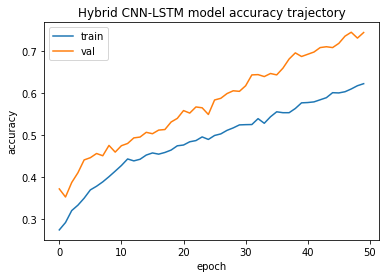

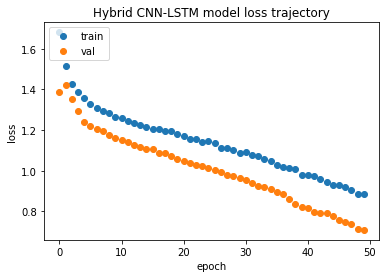

In [20]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
## Testing the hybrid GRU model

gru_score = gru_model.evaluate(x_test_gru, y_test_gru, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',gru_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.39841986
